In [1]:


# !python -m ipykernel install --user --name=tf_env --display-name "Python 3.11 (tf_env)"
!pip install matplotlib seaborn numpy pandas


In [2]:
import os
!pip install tensorflow

In [3]:
import tensorflow as tf
print(tf.__version__)

2.19.0


In [4]:
import tensorflow as tf
from tensorflow import keras

# Model building blocks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display
# Data preprocessing and augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Pre-trained model (our foundation)
from tensorflow.keras.applications import ResNet50

# Evaluation and visualization
from sklearn.metrics import (precision_recall_curve, roc_curve, accuracy_score,
                           confusion_matrix, precision_score, recall_score,
                           classification_report, roc_auc_score)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [5]:
tf.random.set_seed(42)
np.random.seed(42)

In [8]:
# Update this path to the actual location of your 'chest_xray' folder in Google Drive
base_dir = '/content/drive/My Drive/chest_xray'

train_dir = f'{base_dir}/train'
val_dir = f'{base_dir}/val'
test_dir = f'{base_dir}/test'

print(train_dir)
import os
print(os.path.exists(train_dir))

print(os.listdir(train_dir))  # Should show ['NORMAL', 'PNEUMONIA']


/content/drive/My Drive/chest_xray/train
True
['PNEUMONIA', 'NORMAL']


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
base_model = ResNet50(
    weights='imagenet',        # Use weights trained on ImageNet (1.4M images)
    include_top=False,         # Remove the final classification layer
    input_shape=(224, 224, 3)  # Our input: 224x224 RGB images
)

print(f"📊 ResNet-50 has {base_model.count_params():,} parameters")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
📊 ResNet-50 has 23,587,712 parameters


In [10]:
# Freeze all layers in the base model
base_model.trainable = False
trainable_count = sum([1 for layer in base_model.layers if layer.trainable])
total_count = len(base_model.layers)
print(f"📊 Trainable layers: {trainable_count}/{total_count}")

📊 Trainable layers: 0/175


In [11]:
model = Sequential([
    # 1. Feature Extraction (ResNet-50)
    base_model,

    # 2. Global Average Pooling
    GlobalAveragePooling2D(),

    # 3. Dense Layer for Learning
    Dense(256, activation='relu'),

    # 4. Dropout for Regularization
    Dropout(0.5),

    # 5. Output Layer
    Dense(1, activation='sigmoid')  # Binary classification: 0 or 1
])

In [12]:
model.summary()

total_params = np.sum([tf.keras.backend.count_params(w) for w in model.weights])

# trainable parameters
trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])

# non-trainable parameters
non_trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights])



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [13]:
if trainable_params < 1000000:
    print("Good! Small number of trainable parameters")
    print("   • Faster training")
    print("   • Less likely to overfit")
else:
    print("Large number of trainable parameters")
    print("   • Might need more data or regularization")

Good! Small number of trainable parameters
   • Faster training
   • Less likely to overfit


In [14]:
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Adam optimizer with learning rate
    loss='binary_crossentropy',           # Loss function for binary classification
    metrics=['accuracy']                  # Track accuracy during training
)


In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ===============================
# 1️⃣ Create ImageDataGenerators
# ===============================

# Training data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation data: only rescale
val_datagen = ImageDataGenerator(rescale=1./255)

# ===============================
# 2️⃣ Create generators
# ===============================
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    classes=['NORMAL', 'PNEUMONIA'],
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    classes=['NORMAL', 'PNEUMONIA'],
    shuffle=False
)

# ===============================
# 3️⃣ Print generator stats
# ===============================
print("Number of batches in train generator:", len(train_generator))
print("Batch size:", train_generator.batch_size)
print("Total training images:", train_generator.samples)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Number of batches in train generator: 163
Batch size: 32
Total training images: 5216


In [16]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 624 images belonging to 2 classes.


In [18]:
import os

normal_count = len(os.listdir(f'{train_dir}/NORMAL'))
pneumonia_count = len(os.listdir(f'{train_dir}/PNEUMONIA'))
total_samples = normal_count + pneumonia_count

class_weight = {
    0: total_samples / (2.0 * normal_count),      # Weight for NORMAL
    1: total_samples / (2.0 * pneumonia_count)    # Weight for PNEUMONIA
}

print("NORMAL images:", normal_count)
print("PNEUMONIA images:", pneumonia_count)
print("Total training samples:", total_samples)
print("Class weights:", class_weight)


NORMAL images: 1341
PNEUMONIA images: 3875
Total training samples: 5216
Class weights: {0: 1.9448173005219984, 1: 0.6730322580645162}


In [19]:
print(f"   Normal:    {normal_count:,} images ({normal_count/total_samples*100:.1f}%)")
print(f"   Pneumonia: {pneumonia_count:,} images ({pneumonia_count/total_samples*100:.1f}%)")
print(f"   Total:     {total_samples:,} images")

print(f"\n⚖️ CALCULATED CLASS WEIGHTS:")
print(f"   Normal (0):    {class_weight[0]:.3f}")
print(f"   Pneumonia (1): {class_weight[1]:.3f}")
imbalance_ratio = pneumonia_count / normal_count
if imbalance_ratio > 2:
    print(f"⚠️  HIGH IMBALANCE DETECTED: {imbalance_ratio:.1f}:1 ratio")
    print("✅ Class weights will help balance this!")
else:
    print("✅ Moderate imbalance - class weights should handle this well")

   Normal:    1,341 images (25.7%)
   Pneumonia: 3,875 images (74.3%)
   Total:     5,216 images

⚖️ CALCULATED CLASS WEIGHTS:
   Normal (0):    1.945
   Pneumonia (1): 0.673
⚠️  HIGH IMBALANCE DETECTED: 2.9:1 ratio
✅ Class weights will help balance this!


In [20]:
# early_stopping = EarlyStopping(
#     monitor='val_loss',          # Watch validation loss
#     patience=5,                  # Wait 5 epochs for improvement
#     restore_best_weights=True,   # Keep the best weights, not the last
#     verbose=1,                   # Print when it stops
#     mode='min'                   # Lower validation loss is better
# )
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',          # Watch validation loss
    factor=0.2,                  # Reduce LR by factor of 5 (multiply by 0.2)
    patience=3,                  # Wait 3 epochs before reducing
    min_lr=1e-7,                 # Don't go below this learning rate
    verbose=1,                   # Print when LR changes
    mode='min'                   # Lower loss is better
)
checkpoint = ModelCheckpoint(
    filepath='best_pneumonia_model.keras',
    monitor='val_accuracy',      # Save when validation accuracy improves
    save_best_only=True,         # Only save when performance improves
    verbose=1,                   # Print when saving
    mode='max'                   # Higher accuracy is better
)


In [21]:
callbacks = [ reduce_lr, checkpoint]


In [22]:
EPOCHS = 15  # Start with 15 epochs
VERBOSE = 1  # Show progress bar
steps_per_epoch = len(train_generator)
estimated_minutes = (steps_per_epoch * EPOCHS * 3) / 60
print(f"\n⏱️ ESTIMATED TRAINING TIME:")
print(f"🔹 Steps per epoch: {steps_per_epoch}")
print(f"🔹 Estimated time: {estimated_minutes:.0f}-{estimated_minutes*2:.0f} minutes")
print(f"🔹 Note: Actual time depends on your hardware (GPU vs CPU)")


⏱️ ESTIMATED TRAINING TIME:
🔹 Steps per epoch: 163
🔹 Estimated time: 122-244 minutes
🔹 Note: Actual time depends on your hardware (GPU vs CPU)


In [23]:
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [24]:


try:
    batch_x, batch_y = next(train_generator)
    print(f"✅ Training generator working - batch shape: {batch_x.shape}")
    train_generator.reset()  # Reset generator
except:
    print("❌ Training generator issue!")

try:
    batch_x, batch_y = next(val_generator)
    print(f"✅ Validation generator working - batch shape: {batch_x.shape}")
    val_generator.reset()  # Reset generator
except:
    print("❌ Validation generator issue!")

if model.optimizer:
    print("✅ Model compiled successfully")
else:
    print("❌ Model not compiled!")





✅ Training generator working - batch shape: (32, 224, 224, 3)
✅ Validation generator working - batch shape: (16, 224, 224, 3)
✅ Model compiled successfully


In [25]:
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    callbacks=[reduce_lr, checkpoint],
    class_weight=class_weight,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.5341 - loss: 0.7396 
Epoch 1: val_accuracy improved from -inf to 0.75000, saving model to best_pneumonia_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 3681s 22s/step - accuracy: 0.5343 - loss: 0.7393 - val_accuracy: 0.7500 - val_loss: 0.6492 - learning_rate: 0.0010
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 769ms/step - accuracy: 0.6601 - loss: 0.6295
Epoch 2: val_accuracy improved from 0.75000 to 0.81250, saving model to best_pneumonia_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 126s 775ms/step - accuracy: 0.6602 - loss: 0.6294 - val_accuracy: 0.8125 - val_loss: 0.6052 - learning_rate: 0.0010
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 785ms/step - accuracy: 0.7401 - loss: 0.5778
Epoch 3: val_accuracy did not improve from 0.81250
163/163 ━━━━━━━━━━━━━━━━━━━━ 129s 786ms/step - accuracy: 0.7401 - loss: 0.5777 - val_accuracy: 0.6250 - val_loss: 0.5903 - learning_rate: 0.0010
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 783ms/step - a

In [26]:
# Unfreeze the last few layers of ResNet-50
base_model.trainable = True
for layer in base_model.layers[:-20]:  # Keep early layers frozen
    layer.trainable = False

# Recompile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower learning rate
    loss='binary_crossentropy',
    metrics=['accuracy']
)




In [27]:
# Continue training
history_fine = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=callbacks,
    class_weight=class_weight,
    verbose=1
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 794ms/step - accuracy: 0.7014 - loss: 0.6276
Epoch 1: val_accuracy did not improve from 0.81250
163/163 ━━━━━━━━━━━━━━━━━━━━ 155s 823ms/step - accuracy: 0.7019 - loss: 0.6267 - val_accuracy: 0.5000 - val_loss: 0.6593 - learning_rate: 1.0000e-04
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 779ms/step - accuracy: 0.8368 - loss: 0.3919
Epoch 2: val_accuracy did not improve from 0.81250
163/163 ━━━━━━━━━━━━━━━━━━━━ 128s 781ms/step - accuracy: 0.8369 - loss: 0.3917 - val_accuracy: 0.5000 - val_loss: 3.8970 - learning_rate: 1.0000e-04
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 793ms/step - accuracy: 0.8635 - loss: 0.3019
Epoch 3: val_accuracy did not improve from 0.81250
163/163 ━━━━━━━━━━━━━━━━━━━━ 130s 795ms/step - accuracy: 0.8635 - loss: 0.3020 - val_accuracy: 0.8125 - val_loss: 0.6279 - learning_rate: 1.0000e-04
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 800ms/step - accuracy: 0.8653 - loss: 0.3084
Epoch 4: val_accuracy did not improve from 0.812

In [28]:
print(f"\n📊 Evaluating model on test set...")

# Get test predictions
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype(int).flatten()

# Get true labels
true_labels = test_generator.classes

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_classes)
precision = precision_score(true_labels, predicted_classes)
recall = recall_score(true_labels, predicted_classes)
auc = roc_auc_score(true_labels, predictions)

print(f"\n🎯 TEST RESULTS:")
print("=" * 30)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"AUC-ROC:   {auc:.4f}")

# Classification report
print(f"\n📋 Detailed Classification Report:")
print(classification_report(true_labels, predicted_classes,
                          target_names=['Normal', 'Pneumonia']))


📊 Evaluating model on test set...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 382s 20s/step

🎯 TEST RESULTS:
Accuracy:  0.8462
Precision: 0.8930
Recall:    0.8564
AUC-ROC:   0.9283

📋 Detailed Classification Report:
              precision    recall  f1-score   support

      Normal       0.78      0.83      0.80       234
   Pneumonia       0.89      0.86      0.87       390

    accuracy                           0.85       624
   macro avg       0.83      0.84      0.84       624
weighted avg       0.85      0.85      0.85       624



In [29]:
def plot_training_history(history, history_fine=None):
    """Plot training and validation metrics"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Combine histories if fine-tuning was done
    if history_fine:
        acc = history.history['accuracy'] + history_fine.history['accuracy']
        val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
        loss = history.history['loss'] + history_fine.history['loss']
        val_loss = history.history['val_loss'] + history_fine.history['val_loss']
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Accuracy plot
    axes[0].plot(epochs, acc, 'bo-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)

    # Loss plot
    axes[1].plot(epochs, loss, 'bo-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'ro-', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

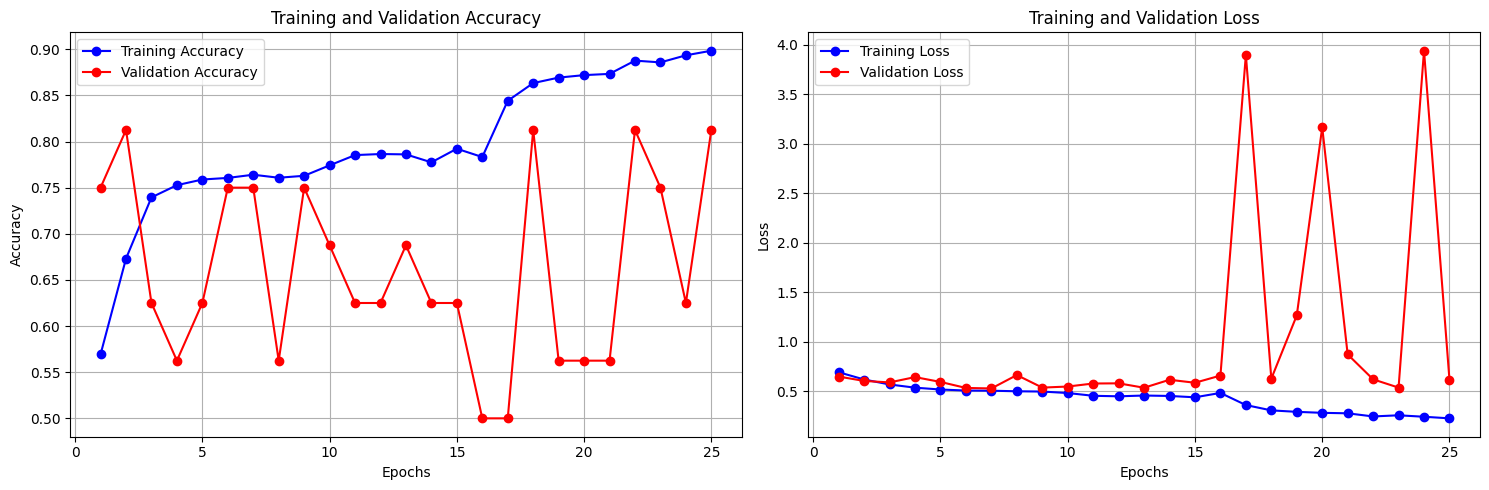

In [30]:
plot_training_history(history, history_fine)

In [31]:
def plot_confusion_matrix(true_labels, predicted_classes):
    """Plot confusion matrix"""
    cm = confusion_matrix(true_labels, predicted_classes)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Pneumonia'],
                yticklabels=['Normal', 'Pneumonia'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [32]:
def plot_roc_curve(true_labels, predictions):
    """Plot ROC curve"""
    fpr, tpr, _ = roc_curve(true_labels, predictions)
    auc = roc_auc_score(true_labels, predictions)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

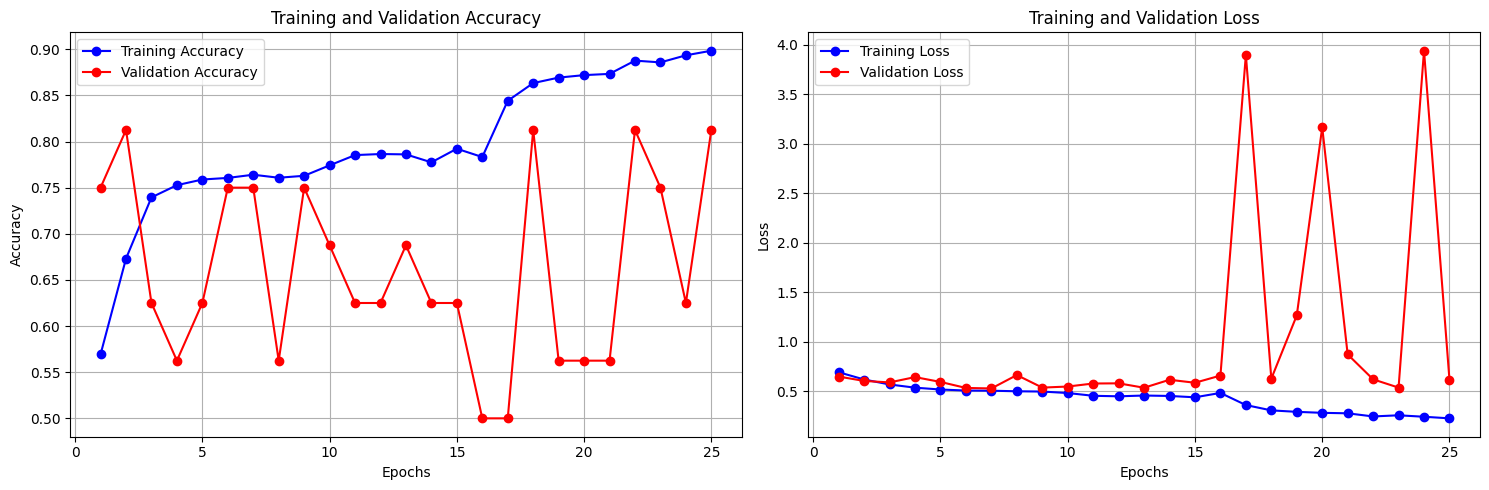

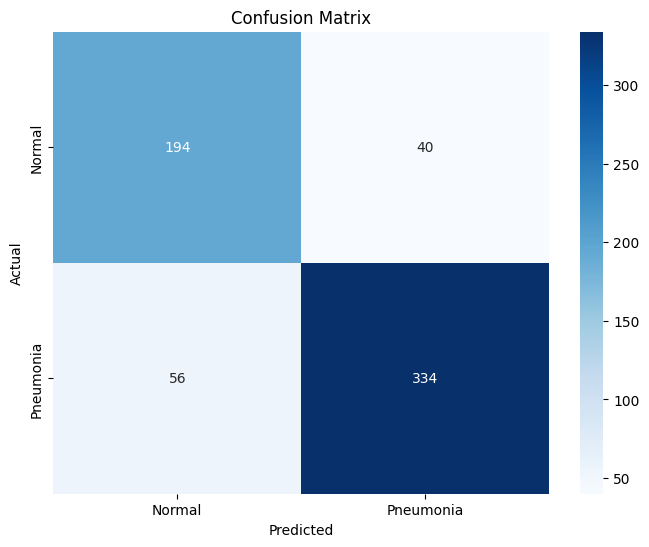

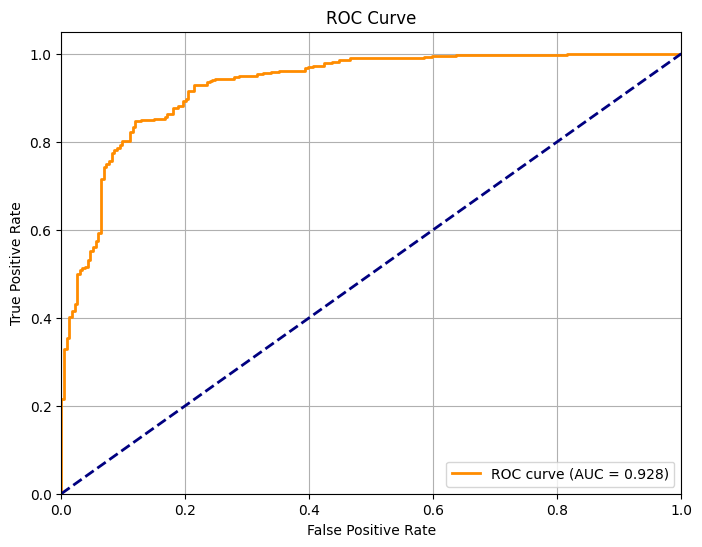

In [33]:
plot_training_history(history, history_fine)
plot_confusion_matrix(true_labels, predicted_classes)
plot_roc_curve(true_labels, predictions)


🖼️ Showing sample predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


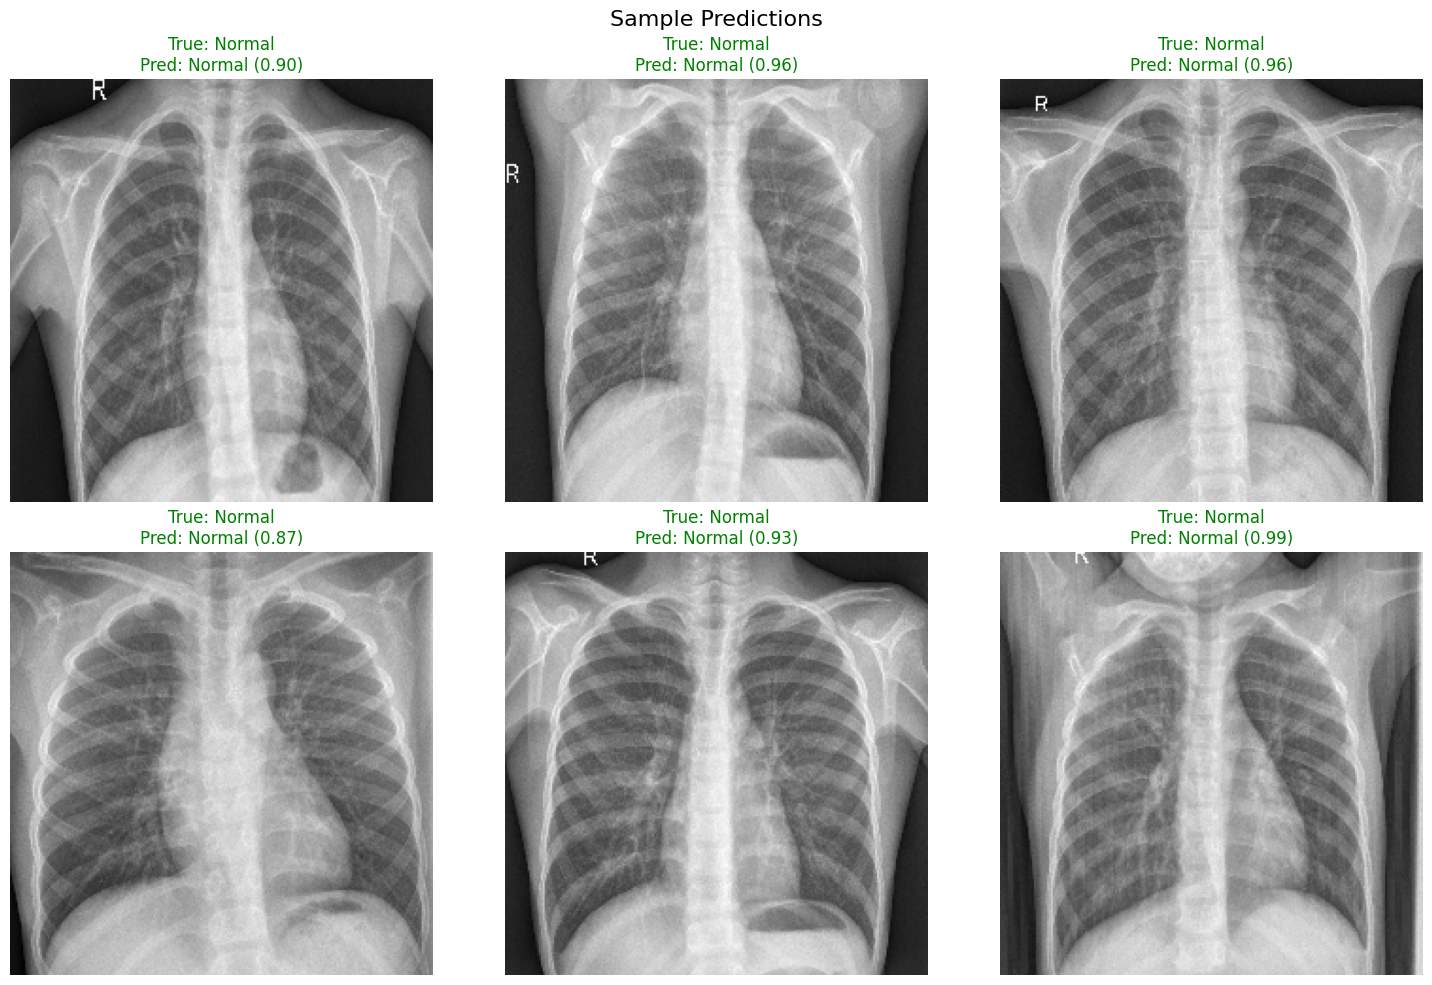

In [36]:
def show_sample_predictions(generator, model, num_samples=6):
    """Show sample predictions with images"""
    generator.reset()
    batch_images, batch_labels = next(generator)
    predictions = model.predict(batch_images)

    plt.figure(figsize=(15, 10))
    for i in range(min(num_samples, len(batch_images))):
        plt.subplot(2, 3, i+1)
        plt.imshow(batch_images[i])

        true_class = 'Pneumonia' if batch_labels[i] == 1 else 'Normal'
        pred_class = 'Pneumonia' if predictions[i] > 0.5 else 'Normal'
        confidence = predictions[i][0] if predictions[i] > 0.5 else 1-predictions[i][0]

        color = 'green' if true_class == pred_class else 'red'
        plt.title(f'True: {true_class}\nPred: {pred_class} ({confidence:.2f})',
                 color=color)
        plt.axis('off')

    plt.suptitle('Sample Predictions', fontsize=16)
    plt.tight_layout()
    plt.show()

print(f"\n🖼️ Showing sample predictions...")
show_sample_predictions(test_generator, model)

In [40]:
model_filename = 'Npneumonia_resnet50_classifier.h5'
model.save(model_filename)


In [38]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load saved model
model = load_model('pneumonia_resnet50_classifier.h5')
img_path = "/content/drive/MyDrive/chest_xray/test/PNEUMONIA/person1_virus_6.jpeg"

# Preprocess the image
img = image.load_img(img_path, target_size=(224, 224))  # or 224x224 depending on your input size
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
prediction = model.predict(img_array)[0][0]

if prediction > 0.5:
    print(f"Prediction: Pneumonia ({prediction*100:.2f}% confidence)")
else:
    print(f"Prediction: Normal ({(1-prediction)*100:.2f}% confidence)")


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Prediction: Pneumonia (99.97% confidence)


In [41]:
!ls -lh Npneumonia_resnet50_classifier.h5


-rw-r--r-- 1 root root 93M Aug 25 13:14 Npneumonia_resnet50_classifier.h5
